## BERT Modelling

Note that due to hardware limitations, this notebook was run inside of google collab. the resulting model is downloaded and imported to 5. Modelling/bert_model

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv(r'/content/train_data.csv', header=0)
test_df = pd.read_csv(r'/content/test_data.csv', header=0)

print(train_df.head())
print(test_df.head())

                                                Text  Target
0  high school be a joke smoke some weed until yo...     1.0
1  where is waldo i think not where is barbara be...     1.0
2  explore curiosity spark by flash explore into ...     0.0
3          i just wan na see what the chase ratio be     0.0
4  after i am shoot it up the school walk do not ...     2.0
                                                Text  Target
0  i dalton barnyard vow to bring father to schoo...     2.0
1  determination in ablaze forge on a path throug...     0.0
2  “ aye yeah i ’ m fixing to shoot up logan high...     2.0
3      arm attack assaults on a boston middle school     2.0
4                you shoot up the school fire monday     2.0


In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score,  precision_score, recall_score,  roc_auc_score, classification_report, confusion_matrix, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
# Encode string labels to integers if necessary
label_encoder = LabelEncoder()
train_df['Target'] = label_encoder.fit_transform(train_df['Target'])
test_df['Target'] = label_encoder.transform(test_df['Target'])

NUM_CLASSES = len(label_encoder.classes_)

In [5]:
# define and tokenize dataset

# Define Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextDataset(train_df['Text'].tolist(), train_df['Target'].tolist(), tokenizer)
test_dataset = TextDataset(test_df['Text'].tolist(), test_df['Target'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:

# Load BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_CLASSES)
model.to(device)

# Training Loop
optimizer = AdamW(model.parameters(), lr=2e-5)

EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {total_loss/len(train_loader)}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 267/267 [01:27<00:00,  3.03it/s]


Epoch 1 loss: 0.41607345919707295


Training Epoch 2: 100%|██████████| 267/267 [01:28<00:00,  3.03it/s]


Epoch 2 loss: 0.13516239965446153


Training Epoch 3: 100%|██████████| 267/267 [01:28<00:00,  3.03it/s]

Epoch 3 loss: 0.046005172267807336


Evaluating: 100%|██████████| 58/58 [00:11<00:00,  4.97it/s]


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       617
           1       0.96      0.87      0.91       613
           2       0.96      1.00      0.98       601

    accuracy                           0.94      1831
   macro avg       0.94      0.94      0.94      1831
weighted avg       0.94      0.94      0.94      1831

Accuracy:  0.9404696886947024
Precision:  0.9412143987822915
Recall:  0.9404696886947024
F1 Score (weighted):  0.9398931835187484

--- Confusion Matrix ---


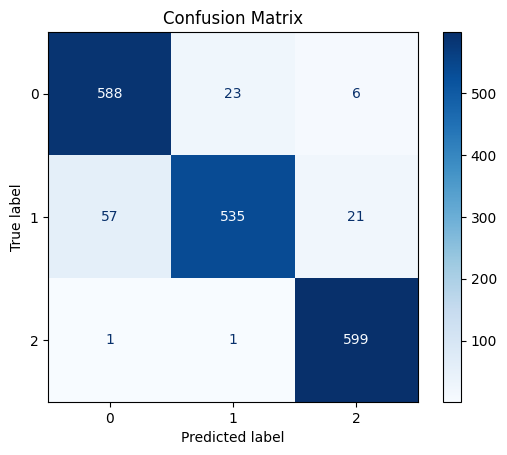

In [11]:
# 8. Evaluation
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# For ROC AUC
y_true_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
roc_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")

# Add Classification Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds))

print(f"Accuracy: ", accuracy_score(all_labels, all_preds))
print(f"Precision: ", precision_score(all_labels, all_preds, average='weighted'))
print(f"Recall: ", recall_score(all_labels, all_preds, average='weighted') )
print(f"F1 Score (weighted): ", f1_score(all_labels, all_preds, average='weighted'))

# confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [8]:
# Save to folder
model.save_pretrained('./saved_bert_model')
tokenizer.save_pretrained('./saved_bert_model')

('./saved_bert_model/tokenizer_config.json',
 './saved_bert_model/special_tokens_map.json',
 './saved_bert_model/vocab.txt',
 './saved_bert_model/added_tokens.json')

In [9]:
import shutil

# Zip the folder
shutil.make_archive('bert_model', 'zip', 'saved_bert_model')

from google.colab import files

# Download the zip file to your local machine
files.download('bert_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>